In [1]:
'''BASIC'''
import numpy as np
import pandas as pd
import random as rand
import datetime
import math
import os
import itertools as itr
import warnings
warnings.simplefilter('ignore')
'''PLOT'''
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
font = {'size':16}
'''STATS'''
import scipy.stats as scs
import statsmodels.api as sm
'''SCIKIT LEARN'''
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, classification_report, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.metrics import roc_curve, auc

from src.plot_confusion_matrix import plot_confusion_matrix



from imblearn.over_sampling import SMOTE

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

'''RETURN'''
os.system("say 'loading complete' &");

In [2]:
def churnpipe(file, disp=False, split=True, impute=True, test_size=0.33, random_state=777):
    # read
    X = pd.read_csv('data/'+file)
    # create labels based on usage in the past 30 days
    y = pd.to_datetime(X.pop('last_trip_date')) < pd.to_datetime('2014-06-01')
    # dummies for null ratings or impute
    if impute == True:
        X['avg_rating_by_driver'].fillna(0, inplace=True)
        X['avg_rating_of_driver'].fillna(0, inplace=True)
    else:
        X['rating_by_driver_missing'] = X['avg_rating_by_driver'].isnull()
        X['rating_of_driver_missing'] = X['avg_rating_of_driver'].isnull()
        X.drop(['avg_rating_by_driver', 'avg_rating_of_driver'], axis=1, inplace=True)
    # dummies for categorical variables
    X = X.join(pd.get_dummies(X['phone'], prefix='phone', prefix_sep='_', dummy_na=True))
    X = X.join(pd.get_dummies(X['city'], prefix='city', prefix_sep='_', dummy_na=True))
    # remove the original variables
    X.drop(['phone', 'city', 'signup_date'], axis=1, inplace=True)
  
    # printout
    if disp == True:
        print(X.describe())
        print(y.value_counts(normalize=True))
    # output
    if split == True:
        return train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X, y


In [3]:
def evaluate_model(clf, X, y):
    predicted = clf.predict(X)
    accuracy = accuracy_score(y, predicted)
    precision = precision_score(y, predicted)
    recall = recall_score(y, predicted)
    F1 = 2 * (precision * recall) / (precision + recall)
    print(f"Accuracy Score: {accuracy}")
    print(f"Precision Score: {precision}")
    print(f"Recall Score: {recall}")
    print(f"F1 Score: {F1}")


In [9]:
def plot_roc(clf,X_train,y_train,X_test,y_test):

    clf.fit(X_train,y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

In [10]:
def mod_opt(X_train,y_train):
    gdbr_grid = {
#                           'max_features': ['sqrt', 'log2', None],
                          'learning_rate': [0.01,0.05,0.1],
                          'min_samples_leaf': [3],

                          'n_estimators': [500,1000],
                          'subsample': [0.5,1],
                          'random_state': [1]}

    gdbr_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gdbr_grid,

                                 cv = 5,
                                 verbose=True,
                                 scoring='precision')
    gdbr_gridsearch.fit(X_train, y_train)

    print("best parameters:", gdbr_gridsearch.best_params_)

    return gdbr_gridsearch.best_estimator_




In [11]:

def feat_importance(best_gdbr_model):

    
    model_opt = best_gdbr_model.fit(X_train,y_train)
    feature_importances = 100*model_opt.feature_importances_ / np.sum(model_opt.feature_importances_)
    feature_importances, feature_names, feature_idxs = \
        zip(*sorted(zip(feature_importances, names, range(len(names)))))

    width = 0.8

    idx = np.arange(len(names))
    plt.barh(idx, feature_importances, align='center')
    plt.yticks(idx, feature_names)

    plt.title("Feature Importance in GradientBoosting Classifier")
    plt.xlabel('Relative Importance of Feature', fontsize=14)
    plt.ylabel('Feature Name', fontsize=14);

In [12]:
def smote_split():

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    return X_train_res, y_train_res 

    print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

    print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
    

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.6min finished


best parameters: {'learning_rate': 0.05, 'min_samples_leaf': 3, 'n_estimators': 1000, 'random_state': 1, 'subsample': 0.5}

Accuracy Score: 0.7907575757575758
Precision Score: 0.8159431909288741
Recall Score: 0.8604903973909892
F1 Score: 0.8376249265138154



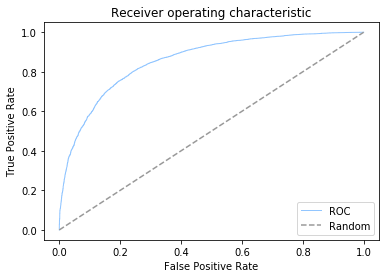


Normalized confusion matrix
[[0.81594319 0.18405681]
 [0.25844708 0.74155292]]


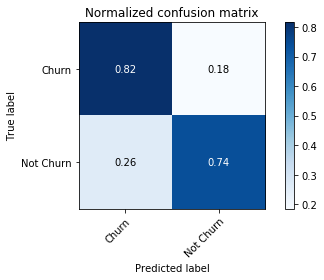

In [13]:
# Scenario 1: impute missing ratings, no oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv')
names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

best_gdbr_model_1 = mod_opt(X_train,y_train)
print()
evaluate_model(best_gdbr_model_1, X_test, y_test)
print()
plot_roc(best_gdbr_model_1 ,X_train,y_train,X_test,y_test)
print()
y_pred = best_gdbr_model_1.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)
print()


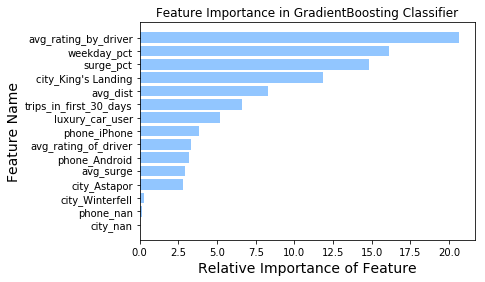

In [14]:
feat_importance(best_gdbr_model_1)


Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 19.9min finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 3, 'n_estimators': 1000, 'random_state': 1, 'subsample': 1}

Accuracy Score: 0.790530303030303
Precision Score: 0.8220794392523364
Recall Score: 0.8499818818697911
F1 Score: 0.835797850228636



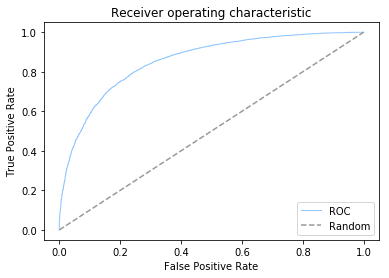


Normalized confusion matrix
[[0.82207944 0.17792056]
 [0.26767241 0.73232759]]


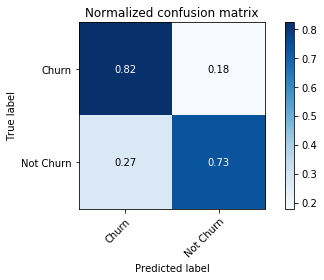

In [15]:
# Scenario 2: impute missing ratings, implement oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv')
names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# Implement oversampling

X_train_res, y_train_res = smote_split()

best_gdbr_model_2 = mod_opt(X_train_res,y_train_res)
print()
evaluate_model(best_gdbr_model_2, X_test, y_test)
print()
plot_roc(best_gdbr_model_2 ,X_train_res,y_train_res,X_test,y_test)
print()
y_pred = best_gdbr_model_2.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()


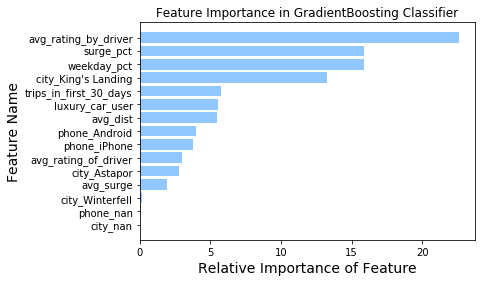

In [16]:
feat_importance(best_gdbr_model_2)

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.7min finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 3, 'n_estimators': 500, 'random_state': 1, 'subsample': 1}

Accuracy Score: 0.7867424242424242
Precision Score: 0.8104545454545454
Recall Score: 0.8614566976688006
F1 Score: 0.8351777036126238



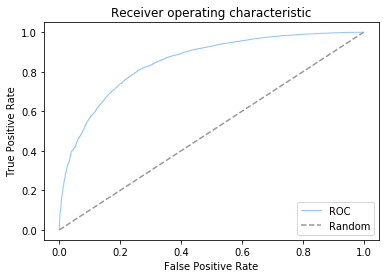


Normalized confusion matrix
[[0.81045455 0.18954545]
 [0.26068182 0.73931818]]


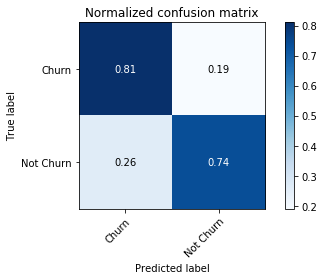

In [17]:
# Scenario 3: not imputing missing ratings, use ratings dummies,no oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv',impute=False)

names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

best_gdbr_model_3 = mod_opt(X_train,y_train)
print()
evaluate_model(best_gdbr_model_3, X_test, y_test)
print()
plot_roc(best_gdbr_model_3 ,X_train,y_train,X_test,y_test)
print()
y_pred = best_gdbr_model_3.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()


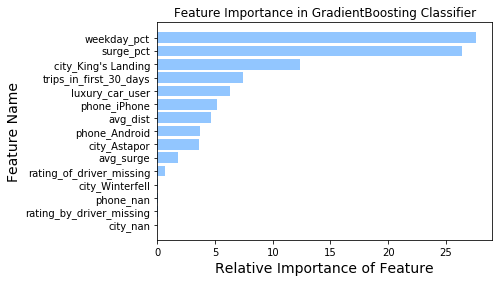

In [18]:
feat_importance(best_gdbr_model_3)

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 20.0min finished


best parameters: {'learning_rate': 0.05, 'min_samples_leaf': 3, 'n_estimators': 1000, 'random_state': 1, 'subsample': 0.5}

Accuracy Score: 0.785530303030303
Precision Score: 0.8246722288438617
Recall Score: 0.8357289527720739
F1 Score: 0.83016377707121



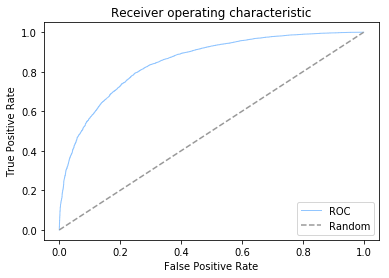


Normalized confusion matrix
[[0.82467223 0.17532777]
 [0.28274428 0.71725572]]


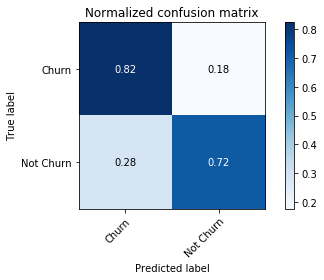

In [19]:
# Scenario 4: not imputing missing ratings, use ratings dummies,implement oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv',impute=False)

names = list(X_train.columns)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# Implement oversampling

X_train_res, y_train_res = smote_split()

best_gdbr_model_4 = mod_opt(X_train_res,y_train_res)
print()
evaluate_model(best_gdbr_model_4, X_test, y_test)
print()
plot_roc(best_gdbr_model_4 ,X_train_res,y_train_res,X_test,y_test)
print()
y_pred = best_gdbr_model_4.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()


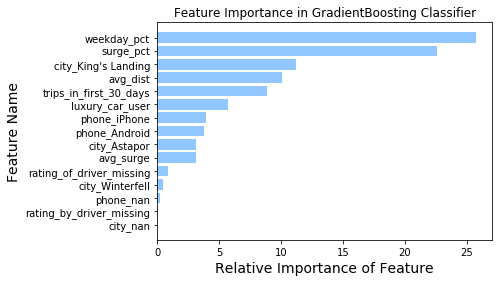

In [20]:
feat_importance(best_gdbr_model_4)

#### Scenario 1 gives the best F1 score.

Fit the model to the entire training data.

In [21]:
# impute missing ratings, no oversampling

X_train, y_train = churnpipe('churn_train.csv', split = False)
names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

best_gdbr_model_final = mod_opt(X_train,y_train)

evaluate_model(best_gdbr_model_final, X_train, y_train)

Before OverSampling, counts of label '1': 24968
Before OverSampling, counts of label '0': 15032 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 20.1min finished


best parameters: {'learning_rate': 0.05, 'min_samples_leaf': 3, 'n_estimators': 1000, 'random_state': 1, 'subsample': 1}
Accuracy Score: 0.80555
Precision Score: 0.8229745979257478
Recall Score: 0.8771627683434796
F1 Score: 0.8492051182628926


Normalized confusion matrix
[[0.8229746  0.1770254 ]
 [0.22908575 0.77091425]]


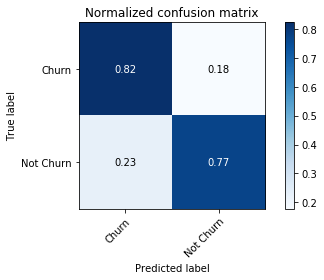

In [22]:
y_pred = best_gdbr_model_final.predict(X_train)
plot_confusion_matrix(y_train, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

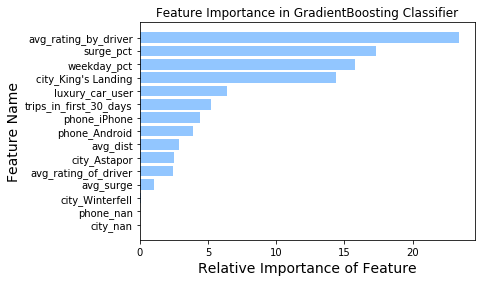

In [23]:
feat_importance(best_gdbr_model_final)

Apple the model to the churn_test data

In [24]:
X,y = churnpipe('churn_test.csv', split=False)
evaluate_model(best_gdbr_model_final, X, y)
print()



Accuracy Score: 0.7852
Precision Score: 0.8068592057761733
Recall Score: 0.861271676300578
F1 Score: 0.8331780055917988



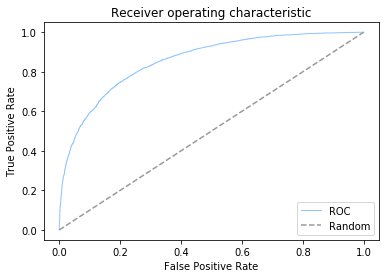

In [25]:
y_prob = best_gdbr_model_final.predict_proba(X)
fpr, tpr, thresholds = roc_curve(y, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show();

Normalized confusion matrix
[[0.80685921 0.19314079]
 [0.25775656 0.74224344]]


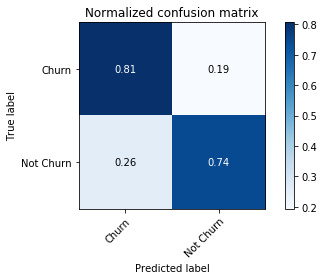

In [26]:
y_pred = best_gdbr_model_final.predict(X)
plot_confusion_matrix(y, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)
